# NAIRU + Output Gap Model

Joint estimation of the non-accelerating inflation rate of unemployment (NAIRU) and the output gap for the Australian economy. The two latent state variables are linked via Okun's Law, providing mutually consistent estimates.

This extends the NAIRU-only model by adding:
1. Potential GDP as a latent random walk process
2. Okun's Law linking the unemployment gap to the output gap

Largely for exploratory purposes only.

#### Acknowledgements

This work has drawn on ideas and approaches in the following:

NAIRU estimation:

 * https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf (Tom Cusbert)

 * https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

 * https://github.com/MacroDave/NAIRU

Output gap and Okun's Law:

 * https://www.rba.gov.au/publications/rdp/2019/2019-07.html (RBA potential output estimates)

 * https://www.imf.org/external/pubs/ft/wp/2012/wp12256.pdf (IMF output gap estimation)

 * Ball, Leigh & Loungani (2017) - Okun's Law: Fit at 50?

## Python set-up

In [1]:
# system imports
from typing import cast

In [2]:
# Analtic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display
from readabs import read_abs_series, read_rba_table
from scipy import stats

In [3]:
# local imports
import mgplot as mg 
import henderson
from abs_structured_capture import ReqsDict, ReqsTuple, get_abs_data

In [4]:
# Plotting set-up
CHART_DIR = "./CHARTS/NAIRU-YGAP/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

RFOOTER = "ABS: 1364.0.15.003"
RFOOTER_OUTPUT = "Joint NAIRU + Output Gap model."

# display charts in this notebook
SHOW = False

## Data capture

#### Utility

In [5]:
def annual_to_quarterly(annual_rate: pd.Series) -> pd.Series:
    """Convert annual inflation expectations to quarterly.
    Formula: ((1 + annual_rate/100)^(1/4) - 1) * 100"""
    return ((1 + annual_rate / 100) ** (1/4) - 1) * 100

In [6]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of
    the three months in each quarter. Ignore quarters with less than
    three months data. Drop NA items."""

    return (
        data.groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(["mean", "count"])
        .apply(lambda x: x["mean"] if x["count"] == 3 else np.nan, axis=1)
        .dropna()
    )

In [7]:
# plot the 2.5% annual inflation target in quarterly terms

QUARTERLY_TARGET = {
    "axhline": {
        "y": (pow(1.025, 0.25) - 1) * 100,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "Quarterly growth consistent with 2.5% annual inflation",
    }
}

QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}

ANNUAL_RANGE = {
    "axhspan": {
        "ymin": 2,
        "ymax": 3,
        "color": "#dddddd",
        "label": "2-3% annual inflation target range",
        "zorder": -1,
    }
}

ANNUAL_TARGET = {
    "axhline": {
        "y": 2.5,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "2.5% annual inflation target",
    }
}

#### Unemployment rate

In [8]:
def get_unemployment() -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, the change in the UE rate, and labor force growth."""

    wanted: ReqsDict = {
        # ReqsTupleL cat, table, did, stype, unit, seek_yr_growth, calc_growth, zip_file
        "Labor Force": 
            ReqsTuple("1364.0.15.003", "1364015003", "Total labour force ;", "S", "", False, False, ""),
        "Unemployed":
            ReqsTuple("1364.0.15.003", "1364015003", "Total unemployed ;", "S", "", False, False, ""),
    }
    data = get_abs_data(wanted)
    u = (data["Unemployed"] / data["Labor Force"]) * 100

    # calculate the change in the UE rate as a proportion of the UE rate
    delta_u = u.diff(1)
    delta_u_1 = delta_u.shift(1)

    # calculate labor force growth (4Q log difference, then quarterised)
    # This captures population growth + participation rate changes, smoothed
    lf_growth_annual = np.log(data["Labor Force"]).diff(4) * 100
    lf_growth_raw = annual_to_quarterly(lf_growth_annual)

    # Apply Henderson moving average and substitute for COVID period
    # to remove the extreme spike/dip distortions
    lf_growth_henderson = henderson.hma(lf_growth_raw.dropna(), 13)
    replace = pd.period_range("2020Q1", "2023Q2", freq="Q")
    lf_growth_henderson = henderson.hma(lf_growth_raw.dropna(), 13)
    lf_growth = lf_growth_raw.where(~lf_growth_raw.index.isin(replace), other=lf_growth_henderson)

    # Plot the data
    common_format = {
        "lfooter": "Australia. Seasonally adjusted series. Quarterly data. ",
        "rfooter": RFOOTER,
        "show": SHOW,
        "y0": True,
    }

    mg.line_plot_finalise(
        u,
        title="Unemployment rate",
        ylabel="Per cent of Labour Force",
        **common_format,
    )

    mg.line_plot_finalise(
        delta_u,
        title="Change in the unemployment rate (ΔU)",
        ylabel="Q/Q Percentage points",
        **common_format,
    )

    # Plot both original and COVID-adjusted labor force growth
    lf_plot_df = pd.DataFrame({
        "Original": lf_growth_raw,
        "COVID-adjusted": lf_growth,
    })
    ax = mg.line_plot(
        lf_plot_df,
        title="Labor Force Growth",
        ylabel="Q/Q Per cent",
        width=2,
    )
    ax.legend(loc="upper right", fontsize="small")
    mg.finalise_plot(
        ax,
        title="Labor Force Growth",
        ylabel="Q/Q Per cent",
        lfooter="Australia. 4Q labor force growth, quarterised. Henderson MA (13-term) substituted for 2020Q1-2023Q2. ",
        rfooter=RFOOTER,
        show=SHOW,
        y0=True,
    )

    # return the values (using COVID-adjusted for the model)
    return u, delta_u, delta_u_1, lf_growth


U, ΔU, ΔU_1, LF_growth = get_unemployment()

Unexpected keyword argument 'title' received by line_plot(). Please check the
function call.
Unexpected keyword argument 'ylabel' received by line_plot(). Please check the
function call.


#### Real GDP

In [9]:
def get_real_gdp() -> tuple[pd.Series, pd.Series]:
    """Get real GDP from ABS National Accounts (5206.0).
    Returns log GDP and quarterly GDP growth."""

    # A2304402X = GDP Chain Volume Measures, Seasonally Adjusted
    nat_accounts, _meta = read_abs_series(cat="5206.0", series_id="A2304402X")
    real_gdp = nat_accounts["A2304402X"]
    
    # Log GDP (for output gap estimation)
    log_gdp = real_gdp.apply(np.log) * 100  # multiply by 100 for percentage scale
    
    # Quarterly GDP growth
    gdp_growth = log_gdp.diff(1)
    
    # Plot
    mg.line_plot_finalise(
        real_gdp,
        title="Real GDP (Chain Volume)",
        ylabel="$ millions",
        lfooter="Australia. Seasonally adjusted. ",
        rfooter="ABS 5206.0",
        show=SHOW,
    )
    
    mg.line_plot_finalise(
        gdp_growth,
        title="Quarterly Real GDP Growth",
        ylabel="Per cent (log difference)",
        lfooter="Australia. Seasonally adjusted. ",
        rfooter="ABS 5206.0",
        y0=True,
        show=SHOW,
    )
    
    return log_gdp, gdp_growth


log_GDP, GDP_growth = get_real_gdp()

#### Labour Productivity (for time-varying potential growth)

In [ ]:
def get_productivity_trend(hma_term: int = 21) -> pd.Series:
    """Get labour productivity (GDP per hour worked) and calculate
    a Henderson moving average as a measure of trend productivity growth.

    This is used to inform time-varying potential GDP growth, based on
    the idea that productivity doesn't matter in the short run but is
    everything in the long run.

    Args:
        hma_term: Henderson filter term (default 21 for ~5 years of quarters)

    Returns:
        Quarterly productivity growth trend (Henderson MA)
    """

    # GDP per hour worked from National Accounts - use data item descriptions
    wanted: ReqsDict = {
        "GDP": ReqsTuple(
            "5206.0", "5206001_Key_Aggregates",
            "Gross domestic product: Chain volume measures ;",
            "S", "", False, False, ""
        ),
        "Hours": ReqsTuple(
            "5206.0", "5206001_Key_Aggregates",
            "Hours worked: Index ;",
            "S", "", False, False, ""
        ),
    }
    data = get_abs_data(wanted)
    productivity_index = data["GDP"] / data["Hours"]

    # Calculate quarterly productivity growth (log difference * 100 for percentage)
    log_productivity = productivity_index.apply(np.log) * 100
    productivity_growth = log_productivity.diff(1).dropna()

    # Apply Henderson moving average (asymmetric weights at endpoints)
    productivity_trend = henderson.hma(productivity_growth, hma_term)

    # Plot
    fig, ax = plt.subplots()
    productivity_growth.plot(ax=ax, label="Quarterly productivity growth", alpha=0.5, lw=1)
    productivity_trend.plot(ax=ax, label=f"{hma_term}-term Henderson MA", lw=2, color="darkorange")
    mg.finalise_plot(
        ax,
        title=f"Labour Productivity Growth ({hma_term}-term Henderson)",
        ylabel="Per cent (quarterly)",
        lfooter="Australia. GDP per hour worked. Seasonally adjusted.",
        rfooter="ABS 5206.0",
        y0=True,
        legend={"loc": "upper right", "fontsize": "x-small"},
        show=SHOW,
    )

    return productivity_trend


productivity_trend = get_productivity_trend(hma_term=21)

#### Inflation

In [11]:
def get_inflation(measure="TM"
) -> tuple[pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get trimmed mean inflation as a measure of core inflation."""

    # -- will need a rework when the CPI is updated in late January 2026 --
    tm = "Percentage Change from Previous Period ;  Trimmed Mean ;  Australia ;"
    tm_annual = "Percentage Change from Corresponding Quarter of Previous Year ;  Trimmed Mean ;  Australia ;" 
    headline = "Percentage Change from Previous Period ;  All groups CPI, seasonally adjusted ;  Australia ;"
    old_cpi = "./ABS-Data/Qrtly-CPI-Time-series-spreadsheets-all.zip"
    wanted = {
    "Trimmed Mean" :
        ReqsTuple("", "640106", tm, "S", "", False, False, old_cpi),
    "Trimmed Mean Annual" :
        ReqsTuple("", "640106", tm_annual, "S", "", False, False, old_cpi),
    "Headline CPI" :
        ReqsTuple("", "640106", headline, "S", "", False, False, old_cpi),
    }
    selected = "Trimmed Mean" if measure == "TM" else "Headline CPI"
    inflation = get_abs_data(wanted)[selected]
    inflation.name = selected  # name for the graphs

    mg.line_plot_finalise(
        inflation,
        title="Q/Q Inflation",
        ylabel="Q/Q Percentage change",
        lfooter="Australia. Seasonally adjusted series. Quarterly data. ",
        rfooter="ABS",
        show=SHOW,
        y0=True,
        tag="qtr",
        legend=True,
        axhspan=QUARTERLY_RANGE["axhspan"],
    )

    pi4 = get_abs_data(wanted)[f"{selected} Annual"]
    pi = inflation
    pi_1 = pi.shift(periods=1).dropna() 
    pi_2 = pi.shift(periods=2).dropna()
    pi_3 = pi.shift(periods=3).dropna()

    delta_pi = pi.diff(1)           # inflation change
    delta_pi_1 = delta_pi.shift(1)  # lagged inflation change
    delta_pi_2 = delta_pi.shift(2)
    delta_pi_3 = delta_pi.shift(3)

    Δ4π_1 = annual_to_quarterly(pi.diff(4).shift(1))  # lagged 4-quarter inflation change/quarterised

    return pi, pi_1, pi_2, pi_3, delta_pi, delta_pi_1, delta_pi_2, delta_pi_3, Δ4π_1, pi4


π, π_1, π_2, π_3, Δπ, Δπ_1, Δπ_2, Δπ_3, Δ4π_1, π4 = get_inflation()

#### Import prices (from ABS 6457)

In [12]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade, _trade_meta = read_abs_series(cat="6457.0", series_id="A2298279F")
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    dlip_1 = delta4_log_import_prices.shift(periods=1).dropna()
    dlip_2 = delta4_log_import_prices.shift(periods=2).dropna()

    # plot the data
    ax = dlip_1.plot(lw=2)
    mg.finalise_plot(
        ax,
        title="Lagged change in import prices (Δ4ρm_1)",
        ylabel="diff(log(Import Price Index))*100",
        y0=True,
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 6457",
        show=SHOW,
    )

    return dlip_1, dlip_2


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()

Table 64570DO001 has no 'Index' sheet.
Table 64570DO002 has no 'Index' sheet.
Table 64570DO003 has no 'Index' sheet.


#### Unit labour costs

In [13]:
def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts, _nat_accounts_meta = read_abs_series(
        cat="5206.0", series_id=["A2304402X", "A2302915V"]
    )
    ulc = nat_accounts["A2302915V"] / nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100

    # plot the data
    term = 13
    trend = henderson.hma(delta_ulc, term)
    mg.line_plot_finalise(
        pd.DataFrame(
            {
                "Qrtly unit labour costs growth": delta_ulc,
                f"{term}-term Henderson moving average": trend,
            }
        ),
        title="Qrtly unit labour costs growth",
        ylabel="diff(log(ULC))*100",
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 5206",
        width=[1.5, 2.5],
        y0=True,
        show=SHOW,
    )
    return delta_ulc


Δulc = get_ulc()

#### Global supply constraints during the COVID-19 period

In [14]:
def get_gscpi() -> tuple[pd.Series, pd.Series]:
    """Global Supply Chain Price Index. Useful for capturing global supply constraints
    associated with the COVID-19 pandemic (and subsequent reopening and the Ukraine war).
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls",
        sheet_name="GSCPI Monthly Data",
        index_col=0,
        parse_dates=True,
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    quarter = pd.Timestamp.today().to_period('Q')
    dummy = pd.Series(1, pd.period_range(start="1959Q1", end=quarter-1, freq="Q"))
    mask = (dummy.index >= "2020Q1") & (dummy.index <= "2023Q2")
    dummy[mask] = 0  # - key dates for the COVID period
    gscpi_1 = gscpi_1.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)
    gscpi_2 = gscpi_2.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)

    mg.line_plot_finalise(
        gscpi,
        title="Global supply constraints",
        ylabel="Index",
        lfooter="Quarterly data. ",
        rfooter="Source: New York Fed",
        width=2,
        y0=True,
        show=SHOW,
    )

    return gscpi_1, gscpi_2


ξ_1, ξ_2 = get_gscpi()

#### Oil price shocks

In [15]:
def get_oil_shock() -> pd.Series:
    """Get oil price shocks for the full sample period.
    Uses World Bank crude oil prices (average of Brent, Dubai, WTI) converted to AUD.
    Returns quarterly log change in AUD oil prices."""
    
    # Get USD oil prices from World Bank Pink Sheet - Historical Data
    url = (
        "https://thedocs.worldbank.org/en/doc/" +
        "18675f1d1639c7a34d463f59263ba0a2-0050012025/related/CMO-Historical-Data-Monthly.xlsx"
    )
    commodities: pd.DataFrame = pd.read_excel(
        url, sheet_name="Monthly Prices", header=6, na_values=['N/A', 'missing', '-', '…'], index_col=0
    )

    oil_monthly: pd.Series = (
        commodities['CRUDE_PETRO']  # international average price
        .astype(float)
    )
    oil_monthly.index = oil_monthly.index.str.replace('M', '-')
    oil_monthly.index = pd.PeriodIndex(oil_monthly.index, freq="Q")

    oil_quarterly: pd.Series = oil_monthly.groupby(oil_monthly.index).mean()

    hist_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist-1969-2009.xls"
    now_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist.xls"

    container = []
    for url in [hist_url, now_url]:
        table = pd.read_excel(url, sheet_name="Data", header=10, index_col=0)
        series: pd.Series = table["FXRUSD"].dropna()
        series.index = pd.PeriodIndex(series.index, freq="Q")
        series = series.groupby(series.index).mean()
        container.append(series)

    aud_usd = pd.concat(container)
    
    # Convert oil to AUD: USD_price / (AUD/USD) = AUD_price
    oil_aud: pd.Series = oil_quarterly.div(aud_usd).dropna()

    # Calculate quarterly log change (percentage change)
    log_oil_aud = oil_aud.apply(np.log)
    delta_log_oil = (log_oil_aud.diff(1) * 100).dropna()
    
    mg.line_plot_finalise(
        delta_log_oil,
        title="Quarterly change in AUD oil prices",
        ylabel="percent change (log difference)",
        lfooter="Quarterly data. World Bank crude oil prices converted to AUD.",
        rfooter="World Bank, RBA",
        width=2,
        y0=True,
        show=SHOW,
    )
    
    return delta_log_oil


oil_shock = get_oil_shock()

#### RBA Cash Rate

In [16]:
def get_rba_cash_rate() -> tuple[pd.Series, pd.Series]:
    """Get the RBA official cash rate.
    
    Returns:
        Tuple of (daily cash rate, quarterly cash rate end-of-period)
    """
    
    import readabs as ra
    
    # Get daily cash rate
    ocr_monthly = ra.read_rba_ocr()
    print(ocr_monthly.index.dtype)
    ocr_monthly.name = "RBA Cash Rate"
    
    # Convert to quarterly (end of quarter value)
    ocr_quarterly = ocr_monthly.copy()
    ocr_quarterly.index = pd.PeriodIndex(ocr_quarterly.index, freq="Q")
    ocr_quarterly = ocr_quarterly.groupby(ocr_quarterly.index).last()
    ocr_quarterly.name = "RBA Cash Rate"
    
    mg.line_plot_finalise(
        ocr_monthly,
        drawstyle="steps-post",
        title="RBA Official Cash Rate (Monthly data)",
        ylabel="Per cent",
        lfooter="Australia. ",
        rfooter="RBA",
        y0=True,
        show=SHOW,
    )
    
    return ocr_monthly, ocr_quarterly


cash_rate_monthly, cash_rate_quarterly = get_rba_cash_rate()

period[M]


## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [17]:
def build_obs() -> tuple[dict[str, np.ndarray], pd.PeriodIndex]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Because the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    observed = pd.DataFrame(
        {
            # Inflation
            "π": π,         # core inflation level
            "π4": π4,       # annual core inflation level
            # Unemployment
            "U": U,  # unemployment rate
            "ΔU": ΔU,  # change in UE rate
            "ΔU_1": ΔU_1,  # lagged change in UE rate
            "ΔU_1_over_U": ΔU_1 / U,  # UE rate change as proportion of UE rate
            # GDP
            "log_gdp": log_GDP,  # log real GDP (scaled by 100)
            "gdp_growth": GDP_growth,  # quarterly GDP growth
            "productivity_trend": productivity_trend,  # 21-term Henderson productivity trend
            "lf_growth": LF_growth,  # labor force growth (pop × participation)
            # Other
            "Δ4ρm_1": Δ4ρm_1,  # annual change in import prices
            "Δulc": Δulc,  # unit labour costs growth
            "ξ_2": ξ_2,  # lagged supply shock
            "oil_shock": oil_shock,  # oil price shocks (full sample)
        }
    )

    print(observed.tail())
    observed = observed.dropna(
        how="any"
    )  # Note ulc comes from Nat Accounts, which is delayed data
    print(
        f"Number of periods: {len(observed)}; from: "
        f"{observed.index[0]}, concluding: {observed.index[-1]}"
    )

    return {str(x): y.to_numpy() for x, y in observed.items()}, cast(
        pd.PeriodIndex, observed.index
    )


obs, obs_index = build_obs()

          π   π4         U        ΔU      ΔU_1  ΔU_1_over_U      log_gdp  \
2024Q4  0.6  3.3  3.923515 -0.198420  0.138805     0.035378  1342.625929   
2025Q1  0.7  2.9  4.042736  0.119221 -0.198420    -0.049081  1342.997307   
2025Q2  0.7  2.7  4.076158  0.033422  0.119221     0.029248  1343.728506   
2025Q3  1.0  3.0  4.237564  0.161406  0.033422     0.007887  1344.119086   
2025Q4  NaN  NaN       NaN       NaN       NaN          NaN          NaN   

        gdp_growth  productivity_trend  lf_growth    Δ4ρm_1      Δulc  ξ_2  \
2024Q4    0.538222           -0.022155   0.459262  1.133371  1.647770  0.0   
2025Q1    0.371378           -0.069303   0.500855  0.446097  1.243498  0.0   
2025Q2    0.731199           -0.123866   0.567605  3.205642  0.624967  0.0   
2025Q3    0.390580           -0.067534   0.406671  2.967577  1.401332  0.0   
2025Q4         NaN                 NaN        NaN       NaN       NaN  NaN   

        oil_shock  
2024Q4  -2.050488  
2025Q1   4.934614  
2025Q2 -15.432

## Bayesian model

### The PyMC model

This model jointly estimates the NAIRU and potential output (output gap) using five equations. All GDP variables ($Y$, $Y^*$) are expressed in **log form** (specifically, $\ln(GDP) \times 100$), ensuring dimensional consistency throughout.

**1. NAIRU State Space Model:**

$$ U^{*}_{t} = U^{*}_{t-1} + \epsilon_{U^*} $$

The NAIRU evolves as a random walk without drift.

**2. Potential Output State Space Model (with time-varying drift):**

$$ Y^{*}_{t} = Y^{*}_{t-1} + \alpha \cdot \bar{g}^{prod}_{t} + \delta \cdot g^{LF}_{t} + \epsilon_{Y^*} $$

Where:
- $Y^*_t$ is **log potential GDP** (scaled by 100)
- $\bar{g}^{prod}_{t}$ is the 21-term Henderson moving average of quarterly labour productivity growth (GDP per hour worked)
- $g^{LF}_{t}$ is quarterly labor force growth (population × participation rate), with Henderson MA substituted for COVID period
- $\alpha$ captures how strongly productivity growth feeds into potential growth (expected ~1)
- $\delta$ captures how labor force growth feeds into potential growth (expected ~1)

Since we work in logs, the first-difference $Y^*_t - Y^*_{t-1}$ represents the **growth rate** of potential GDP. This formulation decomposes potential GDP growth into its two fundamental drivers:

1. **Labour productivity growth** ($\bar{g}^{prod}_{t}$): Output per hour worked, smoothed to capture structural trends
2. **Labour force growth** ($g^{LF}_{t}$): Available labor supply, driven by population and participation

In logs: $\ln(Y) = \ln(L) + \ln(Y/L)$, so growth rates are additive: potential growth ≈ labor force growth + productivity growth.

This captures time-varying effects including:
- Structural productivity slowdown since the GFC
- Immigration waves and pauses (e.g., COVID border closures)
- Participation rate trends (rising female participation, aging workforce)

Note: A residual trend term ($\beta$) was tested but found to be indistinguishable from zero, confirming that productivity + labor force growth fully explain potential output growth.

**3. Price Inflation Equation (Phillips Curve):**

$$ (\pi_{t} - \bar{\pi}) = \rho_{\pi}\Delta_4 \rho^{m}_{t-1} + 
   \gamma_{\pi}\frac{(U_t - U^*_t)}{U_t} + 
   \xi_{\pi}\Xi^2_{t-2} + \theta_{\pi}\omega_t + \epsilon_{\pi}$$

Where:
- $\pi_t$ is quarterly trimmed mean inflation; $\bar{\pi}$ is the quarterly equivalent of the 2.5% annual target
- $\Delta_4 \rho^{m}_{t-1}$ is the **four-quarter change in log import prices** (lagged), capturing external price shocks transmitted through the exchange rate
- $\Xi_{t-2}$ is the **Global Supply Chain Pressure Index** (NY Fed), with the squared term capturing asymmetric COVID-era supply disruptions (2020Q1-2023Q2)
- $\omega_t$ is the quarterly change in AUD-denominated oil prices, capturing energy price shocks
- $\gamma_{\pi}$ is the Phillips curve slope on the unemployment gap

**4. Okun's Law (change form):**

$$ \Delta U_t = \beta_{okun}(Y_t - Y^{*}_t) + \epsilon_{okun} $$

This links the change in unemployment to the output gap. The coefficient $\beta_{okun}$ is expected to be negative: when output exceeds potential (positive output gap), unemployment falls.

This change form is more robust than the levels form, avoiding the need to relate two I(1) series directly.

**5. Wage Growth Equation:**

$$ \Delta ulc_t = \alpha_{wg} + \gamma_{wg}\frac{(U_t - U^*_t)}{U_t} + 
   \lambda_{wg}\frac{\Delta U_{t-1}}{U_t} + \epsilon_{wg}$$

Where $\Delta ulc_t$ is **quarterly growth in unit labour costs** (compensation per unit of output), used as a proxy for underlying wage inflation. The $\lambda_{wg}$ term captures "speed limit" effects where rapid changes in unemployment affect wage pressures beyond the level of the gap.

**Key Design Choices:**

1. **Log specification**: All GDP variables are in logs, so first-differences represent growth rates and the equations are dimensionally consistent.

2. **Joint estimation**: The NAIRU and potential output are estimated simultaneously, with Okun's Law providing the link between the two gaps.

3. **Time-varying drift**: Potential output growth varies over time based on the 21-term Henderson MA of labour productivity and labor force growth, capturing structural changes in the economy's growth capacity.

4. **Okun's Law in changes**: The relationship between unemployment changes and output gaps helps identify potential output while avoiding levels-on-levels regression issues.

5. **Output gap calculation**: After estimation, output gap = $(Y - Y^*)/Y^*$ as a percentage deviation from potential.

**Note on sample period:** 

The model is estimated using data from 1984-Q3 onwards. When estimated using only post-1993 data (the inflation targeting era), the model exhibited 130 divergences during sampling, suggesting the earlier data provides important information for identifying the latent states. The full sample is retained for model stability, though users should be aware that the pre-1993 period reflects a different monetary policy regime.

In [18]:
def set_model_coefficients(model: pm.Model, settings: dict, constant: dict) -> dict:
    """Set model coefficients from a settings dictionary. Return those
    coefficients in a dictionary.
    Note: the coefficients are typically stochastic variables in the model,
    using the normal distribution if mu is specified, or the half-normal."""

    coefficients = {}
    with model:
        for key in settings:
            if key in constant:
                coefficients[key] = constant[key]
                continue
            if "mu" in settings[key]:
                coefficients[key] = pm.Normal(key, **settings[key])
                continue
            coefficients[key] = pm.HalfNormal(key, **settings[key])
        
        # Add any fixed coefficients from constant that weren't in settings
        for key in constant:
            if key not in coefficients:
                coefficients[key] = constant[key]

    return coefficients


# Inflation target: 2.5% annual, converted to quarterly
PI_TARGET_QUARTERLY = (1.025 ** 0.25 - 1) * 100  # ≈ 0.617%

In [19]:
def nairu_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict | None = None,
) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU. This is a state space equation."""

    if constant is None:
        constant = {}

    with model:
        settings = {
            "nairu_innovation": {"mu": 0.3, "sigma": 0.1},
        }
        mc = set_model_coefficients(model, settings, constant)

        nairu = (
            pm.GaussianRandomWalk(
                "nairu",
                mu=0,  # no drift in this model
                sigma=mc["nairu_innovation"],
                init_dist=pm.Normal.dist(mu=15.0, sigma=8.0),
                steps=len(inputs["U"]) - 1,
            )
            if "nairu" not in constant
            else constant["nairu"]
        )

    return nairu

In [20]:
def potential_output_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict | None = None,
) -> pm.GaussianRandomWalk:
    """Potential output with time-varying drift informed by productivity and labor force.
    
    Potential growth is modelled as:
        drift_t = α * productivity_trend_t + δ * lf_growth_t + ε
    
    Where:
        - productivity_trend_t is the 21-term Henderson MA of labour productivity growth
        - lf_growth_t is quarterly labor force growth (population × participation)
        - α captures how strongly productivity feeds into potential (expected ~1)
        - δ captures how labor force growth feeds into potential (expected ~1)
    
    This decomposes potential GDP growth into its two fundamental drivers:
        1. Labor productivity growth (output per hour worked)
        2. Labor force growth (available labor supply)
    
    In logs: Y = L + (Y/L), so growth rates are additive.
    
    This formulation allows potential GDP growth to vary over time based on 
    both productivity trends AND demographic/participation changes, capturing:
        - Structural productivity slowdown since the GFC
        - Immigration waves and pauses (e.g., COVID)
        - Participation rate trends (female participation, aging)
    
    Note: A residual trend term (beta_potential) was tested but found to be
    indistinguishable from zero, confirming that productivity + labor force
    growth fully explain potential output growth.
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "alpha_potential": {"mu": 1.0, "sigma": 0.3},  # productivity pass-through (~1)
            "delta_potential": {"mu": 1.0, "sigma": 0.3},  # labor force pass-through (~1)
            "potential_innovation": {"mu": 0.1, "sigma": 0.05},
        }
        mc = set_model_coefficients(model, settings, constant)

        # Time-varying drift based on productivity trend and labor force growth
        drift = (
            mc["alpha_potential"] * inputs["productivity_trend"] 
            + mc["delta_potential"] * inputs["lf_growth"]
        )

        # Initial value close to first observed log GDP
        init_value = inputs["log_gdp"][0]
        
        # Build potential output manually since GaussianRandomWalk doesn't support
        # time-varying drift directly. We use a cumulative sum approach.
        
        # Innovation term (random shocks to potential)
        innovations = pm.Normal(
            "potential_innovations",
            mu=0,
            sigma=mc["potential_innovation"],
            shape=len(inputs["log_gdp"]),
        )
        
        # Potential output = initial + cumulative(drift + innovations)
        # cumsum of (drift + innovations) gives the random walk with time-varying drift
        potential_output = pm.Deterministic(
            "potential_output",
            init_value + pm.math.cumsum(drift + innovations)
        )

    return potential_output

In [21]:
def okun_law_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    potential_output: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Okun's Law linking output gap to change in unemployment.
    
    Change form of Okun's Law:
        ΔU = β × output_gap + ε
        ΔU = β × (Y - Y*) + ε
    
    Where:
        - ΔU is the observed quarterly change in unemployment rate (pp)
        - output_gap = (log_gdp - potential_output), i.e. (Y - Y*) in log terms
        - β is negative: when Y > Y* (positive gap), unemployment falls (ΔU < 0)
    
    This change form avoids relating two I(1) series and is more robust.
    
    Interpretation of β (beta_okun):
        - Expected to be negative
        - When output is 1% above potential, unemployment changes by β pp
        - Typical values: β ≈ -0.1 to -0.3 for quarterly data
        - E.g., β = -0.2 means 1% output gap → -0.2pp change in unemployment
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "beta_okun": {"mu": -0.2, "sigma": 0.15},  # Okun coefficient for change form
            "epsilon_okun": {"sigma": 0.5},  # error term for ΔU
        }
        mc = set_model_coefficients(model, settings, constant)

        # output gap: (Y - Y*) in log terms (already scaled by 100, so units are %)
        output_gap = inputs["log_gdp"] - potential_output
        
        # Okun's Law (change form): ΔU = β × output_gap
        # When Y > Y* (positive gap), unemployment falls (ΔU < 0 with β < 0)
        _okun = pm.Normal(
            "okun_law",
            mu=mc["beta_okun"] * output_gap,
            sigma=mc["epsilon_okun"],
            observed=inputs["ΔU"],
        )

In [22]:
def price_inflation_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Inflation likelihood equation - deviation from target.
    
    Simplified: inflation deviation from target driven primarily by unemployment gap.
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "rho_pi": {"mu": 0.0, "sigma": 0.1},       # import prices pass-through
            "gamma_pi": {"mu": -1.0, "sigma": 0.5},    # unemployment gap - loosened
            "xi_2sq_pi": {"mu": 0.0, "sigma": 0.1},    # COVID disruptions
            "theta_pi": {"mu": 0.0, "sigma": 0.1},     # oil price shocks
            "epsilon_pi": {"sigma": 0.25},             # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        # Calculate unemployment gap
        u_gap = (inputs["U"] - nairu) / inputs["U"]
        
        # Calculate inflation deviation from target
        pi_dev = inputs["π"] - PI_TARGET_QUARTERLY

        # likelihood
        _observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu=mc["rho_pi"] * inputs["Δ4ρm_1"]  # import prices
            + mc["gamma_pi"] * u_gap  # unemployment gap
            + mc["xi_2sq_pi"] * inputs["ξ_2"] ** 2 * np.sign(inputs["ξ_2"])  # COVID
            + mc["theta_pi"] * inputs["oil_shock"],  # oil price shocks
            sigma=mc["epsilon_pi"],
            observed=pi_dev,
        )

In [23]:
def wage_growth_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Wage growth likelihood equation - minimal specification."""

    if constant is None:
        constant = {}

    with model:
        settings = {
            "alpha_wg": {"mu": 0, "sigma": 1.0},        # intercept
            "gamma_wg": {"mu": -1.5, "sigma": 1.0},     # unemployment gap
            "lambda_wg": {"mu": -4.0, "sigma": 2.0},    # UE rate change (speed limit)
            "epsilon_wg": {"sigma": 1.0},              # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        _observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu=mc["alpha_wg"]
                  + mc["gamma_wg"] * ((inputs["U"] - nairu) / inputs["U"])
                  + mc["lambda_wg"] * inputs["ΔU_1_over_U"],
            sigma=mc["epsilon_wg"],
            observed=inputs["Δulc"],
        )

In [24]:
def define_model(inputs: dict[str, np.ndarray]) -> pm.Model:
    """Define the joint NAIRU + Output Gap model."""

    model = pm.Model()

    # Fix innovation parameters for better convergence
    # Note: potential drift is now time-varying based on productivity trend
    nairu_const = {"nairu_innovation": 0.4}
    potential_const = {"potential_innovation": 0.3}
    
    # State space equations
    nairu = nairu_equation(inputs, model, constant=nairu_const)
    potential_output = potential_output_equation(inputs, model, constant=potential_const)
    
    # Okun's Law - links the two gaps
    okun_law_equation(inputs, model, nairu, potential_output)
    
    # Price inflation equation
    price_inflation_equation(inputs, model, nairu, constant={})
    
    # Wage equation
    wage_growth_equation(inputs, model, nairu)

    return model


the_model = define_model(inputs=obs)

#### Fit the model to the data

In [25]:
N_CORES: int = 6
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 5_000  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
    "target_accept": 0.9,  # increased from default 0.8 to reduce divergences
}

In [26]:
def fit_the_model(model: pm.Model, args: dict) -> az.InferenceData:
    """Fit the data to the model."""

    with model:
        idata = pm.sample(
            **args,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata

### Run the model

/Users/bryanpalmer/ABS/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling.. :   0%|          | 0/21666 [00:00<?, ?it/s]



















Running chain 0:   0%|          | 0/21666 [00:01<?, ?it/s]










Running chain 0:   5%|▍         | 1083/21666 [00:04<01:02, 327.73it/s]











Running chain 0:  10%|▉         | 2166/21666 [00:06<00:46, 416.48it/s]









Running chain 0:  15%|█▍        | 3249/21666 [00:08<00:38, 484.35it/s]












Running chain 0:  20%|█▉        | 4332/21666 [00:10<00:32, 526.71it/s]









Running chain 0:  25%|██▍       | 5415/21666 [00:12<00:32, 495.85it/s]
















Running chain 0:  30%|██▉       | 6498/21666 [00:15<00:35, 423.28it/s]












Running chain 0:  35%|███▍      | 7581/21666 [00:18<00:36, 387.74it/s]












Running chain 0

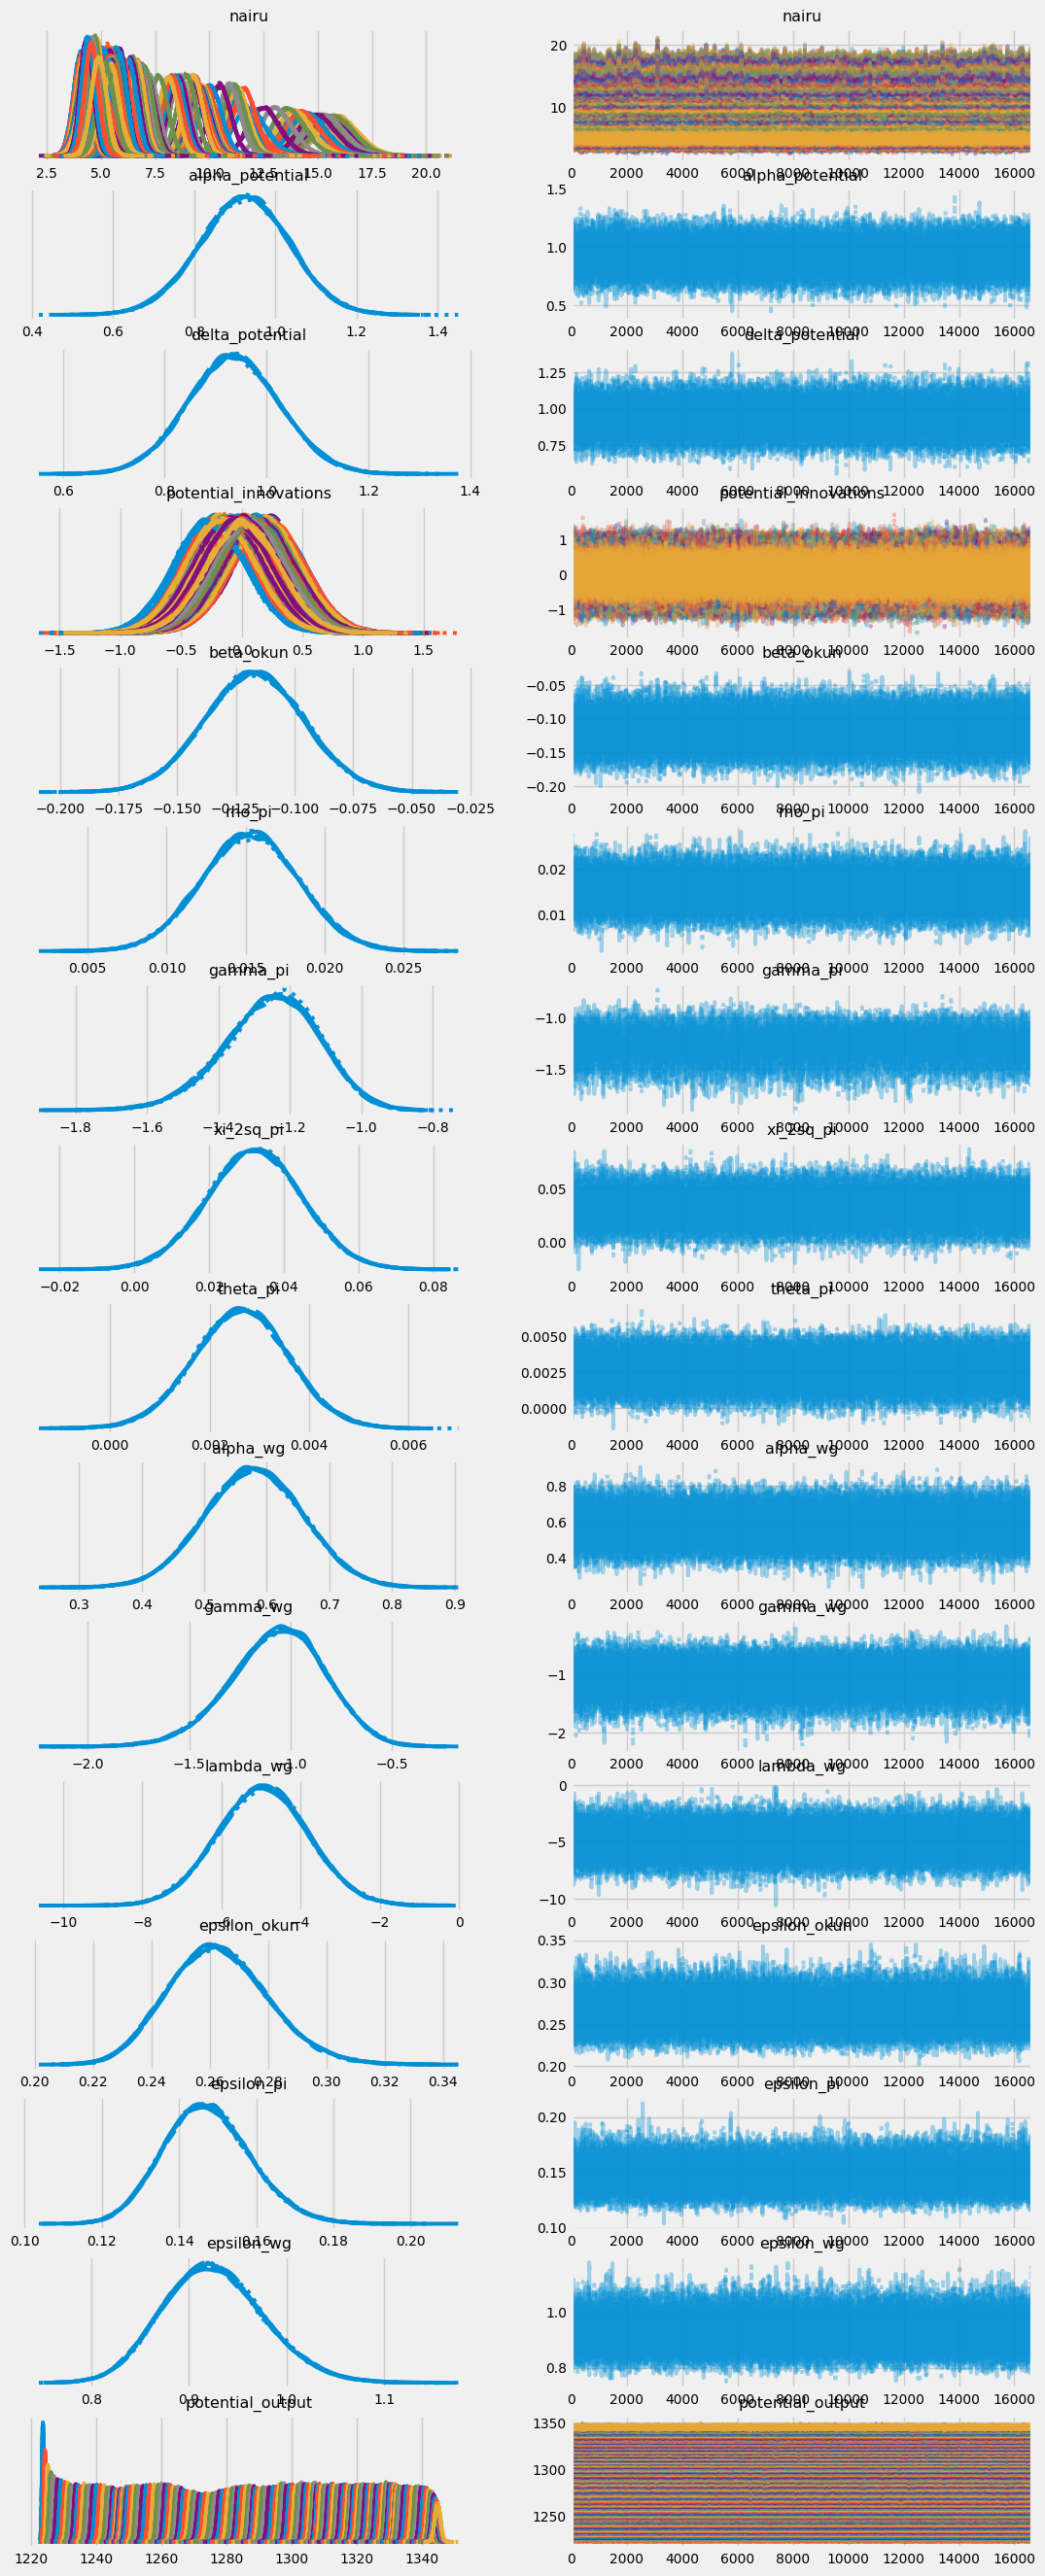

In [27]:
inference_data = fit_the_model(the_model, SAMPLE_ARGS)

# Note: takes under 4 minutes to run on an M4-Pro Mac mini

### Check diagnostics

In [28]:
def check_inference_data(trace: az.InferenceData) -> None:
    """Check the inference data for potential problems."""

    def warn(w: bool) -> str:
        return "--- THERE BE DRAGONS ---> " if w else ""

    summary = az.summary(trace)

    # check model convergence
    max_r_hat = 1.01
    statistic = summary.r_hat.max()
    print(
        f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}"
    )

    # check effective sample size
    min_ess = 400
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(
        f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {int(statistic)}"
    )

    # check for divergences
    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))
    except (ValueError, AttributeError):
        diverging_count = 0
    print(
        f"{warn(diverging_count > 0)}Divergent transitions in HMC sampling: {diverging_count}"
    )

    # check BFMI
    min_bfmi = 0.3
    statistic = az.bfmi(trace).min()
    print(
        f"{warn(statistic < min_bfmi)}Minimum Bayesian fraction of missing information: {statistic:0.2f}"
    )


check_inference_data(inference_data)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 6215
Divergent transitions in HMC sampling: 0
Minimum Bayesian fraction of missing information: 0.86


## Results

### Samples extraction

In [29]:
def get_vector_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a vector variable (e.g., nairu).
    Returns DataFrame with rows=time periods, columns=samples."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )


def get_scalar_var(var_name: str, trace: az.InferenceData) -> pd.Series:
    """Extract the chains/draws for a scalar variable (e.g., coefficients).
    Returns Series of posterior samples."""

    return az.extract(trace, var_names=var_name).to_dataframe()[var_name]

### Plot NAIRU

In [30]:
def plot_nairu(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    # --- primary data collection 
    start = pd.Period("1985Q1", freq="Q")
    nairu = get_vector_var("nairu", trace)
    nairu.index = input_index  # Keep PeriodIndex for fill_between_plot
    nairu = nairu[nairu.index >= start]
    nairu_median = nairu.quantile(q=0.5, axis=1)
    nairu_median.name = "NAIRU Median"
    
    # --- NAIRU with confidence bands
    cuts = (2.5, 16)
    alphas = (0.1, 0.3)
    ax = None
    for i, p in enumerate(cuts):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]:0.0f}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        band_df = pd.DataFrame({"lower": lower, "upper": upper}, index=nairu.index)
        ax = mg.fill_between_plot(
            band_df,
            ax=ax,
            color="blue",
            alpha=alphas[i],
            label=label,
        )
    mg.line_plot(
        nairu_median,
        ax=ax,
        color="darkblue",
        width=1,
        annotate=True,
    )

    # --- unemployment and inflation rates - white background then series
    u = unemployment[unemployment.index >= start]
    inflation = π4[π4.index >= start]
    for color, width, label in zip(["white", ""], [3, 1], ["_", ""]):
        u.name = "Unemployment Rate" if not label else label
        mg.line_plot(
            u,
            ax=ax,
            color=color if color else "blue",
            width=width,
        )
        inflation.name = "Inflation rate" if not label else label
        mg.line_plot(
            inflation,
            ax=ax,
            color=color if color else "orange",
            width=width,
        )

    # --- mark progressive changes to the NAIRU
    if ax is not None:
        ymin, _ymax = ax.get_ylim()
        period = pd.Period("1985Q1", freq="Q")
        while period < input_index[-1]:
            index = period.to_timestamp()
            progress = round(nairu.loc[period].quantile(0.5), 1)
            ax.text(
                index,  # type: ignore[arg-type]
                ymin + 0.2,
                f"{progress}",
                va="bottom",
                ha="center",
                color="black",
                fontsize=8,
            )
            period += 20  # 5 years = 20 quarters

    # --- finalise plot
    if ax is not None:
        mg.finalise_plot(
            ax,
            title="NAIRU Estimate for Australia (Joint Model)",
            ylabel="Per cent",
            legend={"loc": "best", "fontsize": "x-small"},
            lfooter="Australia. ",
            rfooter=RFOOTER_OUTPUT,
            **ANNUAL_RANGE,
            **ANNUAL_TARGET,
            show=SHOW,
        )


plot_nairu(inference_data, U, obs_index)

/Users/bryanpalmer/ABS/.venv/lib/python3.14/site-packages/mgplot/finalise_plot.py:374: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(pad=TIGHT_LAYOUT_PAD)


### Plot Output Gap

In [31]:
def plot_output_gap(
    trace: az.InferenceData,
    log_gdp: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the output gap as percentage deviation from potential."""

    # --- primary data collection
    start = pd.Period("1985Q1", freq="Q")
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index
    
    # Calculate output gap: (Y - Y*)/Y* * 100
    actual_gdp = log_gdp.reindex(input_index).values
    output_gap = (actual_gdp[:, np.newaxis] - potential.values) / potential.values * 100
    output_gap = pd.DataFrame(output_gap, index=input_index)
    output_gap = output_gap[output_gap.index >= start]
    output_gap_median = output_gap.quantile(q=0.5, axis=1)
    output_gap_median.name = "Output Gap Median"
    
    # --- Output gap with confidence bands
    cuts = (2.5, 16)
    alphas = (0.1, 0.3)
    ax = None
    for i, p in enumerate(cuts):
        quants = p, 100 - p
        label = f"Output Gap {quants[1] - quants[0]:0.0f}% HDI"
        lower, upper = [output_gap.quantile(q=q / 100.0, axis=1) for q in quants]
        band_df = pd.DataFrame({"lower": lower, "upper": upper}, index=output_gap.index)
        ax = mg.fill_between_plot(
            band_df,
            ax=ax,
            color="green",
            alpha=alphas[i],
            label=label,
        )
    mg.line_plot(
        output_gap_median,
        ax=ax,
        color="darkgreen",
        width=1,
        annotate=True,
    )
    
    # Add zero line
    if ax is not None:
        ax.axhline(y=0, color="darkred", linestyle="--", linewidth=1)

        mg.finalise_plot(
            ax,
            title="Output Gap Estimate for Australia",
            ylabel="Per cent of potential GDP",
            legend={"loc": "best", "fontsize": "x-small"},
            lfooter="Australia. (Y - Y*)/Y*. Joint NAIRU + Output Gap estimation. ",
            rfooter=RFOOTER_OUTPUT,
            show=SHOW,
        )


plot_output_gap(inference_data, log_GDP, obs_index)

### Plot Actual vs Potential GDP

In [32]:
def plot_gdp_vs_potential(
    trace: az.InferenceData,
    log_gdp: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot actual GDP against potential GDP estimates."""

    # --- primary data collection
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index
    
    # Get median and HDI for potential
    potential_median = potential.quantile(0.5, axis=1)
    potential_median.name = "Potential GDP (median)"
    potential_lower = potential.quantile(0.025, axis=1)
    potential_upper = potential.quantile(0.975, axis=1)
    
    # Actual GDP
    actual = log_gdp.reindex(input_index)
    actual.name = "Actual GDP"
    
    # --- Plot potential GDP band
    band_df = pd.DataFrame({"lower": potential_lower, "upper": potential_upper}, index=potential.index)
    ax = mg.fill_between_plot(
        band_df,
        color="green",
        alpha=0.2,
        label="Potential GDP 95% HDI",
    )
    mg.line_plot(
        potential_median,
        ax=ax,
        color="green",
        width=2,
    )
    
    # Plot actual GDP
    mg.line_plot(
        actual,
        ax=ax,
        color="black",
        width=1.5,
    )

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Actual vs Potential GDP",
            ylabel="Log GDP (scaled)",
            legend={"loc": "upper left", "fontsize": "x-small"},
            lfooter="Australia. Log real GDP scaled by 100. ",
            rfooter=RFOOTER_OUTPUT,
            show=SHOW,
        )


plot_gdp_vs_potential(inference_data, log_GDP, obs_index)

### Plot Potential Growth (proxy for r*)

In [33]:
def plot_potential_growth(
    trace: az.InferenceData,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot annual potential GDP growth (4Q difference of log potential).

    This serves as a proxy for r* (the natural rate of interest), based on
    the theoretical relationship r* ≈ trend real GDP growth.

    It is also the maximum rate at which we can run economic growth before
    inflationary pressures build up.
    """
    from scipy import stats

    # --- primary data collection
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # Calculate annual potential growth: 4Q difference of log potential
    # Since potential is log(GDP)*100, the diff is already in percentage points
    potential_growth = potential.diff(4).dropna()

    # Get median for regression line
    median_growth = potential_growth.quantile(0.5, axis=1)
    median_growth.name = "Potential Growth (median)"

    # --- Potential growth with confidence bands
    cuts = (2.5, 16)
    alphas = (0.1, 0.3)
    ax = None
    for i, p in enumerate(cuts):
        quants = p, 100 - p
        label = f"Potential Growth {quants[1] - quants[0]:0.0f}% HDI"
        lower, upper = [potential_growth.quantile(q=q / 100.0, axis=1) for q in quants]
        band_df = pd.DataFrame({"lower": lower, "upper": upper}, index=potential_growth.index)
        ax = mg.fill_between_plot(
            band_df,
            ax=ax,
            color="purple",
            alpha=alphas[i],
            label=label,
        )
    mg.line_plot(
        median_growth,
        ax=ax,
        color="darkviolet",
        width=1,
        annotate=True,
    )

    # Add regression line on median
    x_numeric = np.arange(len(median_growth))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, median_growth.values)
    trend_line = pd.Series(intercept + slope * x_numeric, index=median_growth.index)
    trend_line.name = f"Trend (slope: {slope * 4:.2f}pp/year)"
    mg.line_plot(
        trend_line,
        ax=ax,
        color="darkred",
        width=1.5,
        style="--",
    )

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Non-Inflationary GDP Growth Rate (proxy for $r^*$)",
            ylabel="Per cent per annum",
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter="Australia. 4-quarter change in log potential GDP. r* ≈ trend growth.",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )


plot_potential_growth(inference_data, obs_index)

### Taylor Rule Assessment

The Taylor Rule provides a benchmark for monetary policy:

$ i_t = r^* + \pi_{coef} \cdot \pi_t - 0.5\pi^* + 0.5 \cdot y_{gap} $

Where:
- $i_t$ = prescribed nominal policy rate
- $r^*$ = neutral real rate (hybrid: 75% trend + 25% raw)
- $\pi_{coef}$ = time-varying inflation coefficient (1.6→1.2 over sample)
- $\pi_t$ = actual annual inflation 
- $\pi^*$ = target inflation (2.5%)
- $y_{gap}$ = output gap (%)

**Choice of r\***: We use a hybrid approach:
- 75% from linear trend (fitted to raw potential growth, captures secular decline)
- 25% from raw model estimate (retains some cyclical signal)

**Time-varying inflation coefficient**: The response to inflation declines from 1.6 to 1.2 over the sample, reflecting:
- Early period: aggressive response needed to establish credibility
- Later period: anchored expectations + exchange rate channel allow lower coefficient
- Theoretical floor: must exceed 1.0 for stability (Taylor Principle)
- Endpoint coefficient (1.2) broadly consistent with RBA research estimates

**Caveats**:
- Policy rules like Taylor’s are interpretive tools, not speed limits. They can illuminate whether policy is broadly tight or loose relative to historical norms, but they cannot capture the full information set, the non-linearities or the judgement calls that shape real-world decisions. 
- Since the GFC, policy rates have run persistently below Taylor-rule benchmarks because the economic environment fundamentally changed. The neutral rate fell, inflation repeatedly undershot targets, and economies grappled with balance-sheet repair and chronic demand weakness. Central banks also adopted a risk-management mindset in the face of uncertainty and financial instability, placing greater weight on avoiding deflation and the lower bound. As a result, actual policy was looser than what a simple Taylor rule - estimated on pre-crisis dynamics - would prescribe.
- Model uncertainty is real (see those confidence bands). 

In [34]:
def plot_taylor_rule(
    trace: az.InferenceData,
    inflation_annual: pd.Series,
    cash_rate_monthly: pd.Series,
    input_index: pd.PeriodIndex,
    r_star_window: int = 16,  # 4 years in quarters
    pi_target: float = 2.5,
    pi_coef_start: float = 1.6,
    pi_coef_end: float = 1.2,
    r_star_trend_weight: float = 0.75,  # 0 = pure smooth, 1 = pure trend
) -> None:
    """Plot Taylor Rule prescribed rate vs actual RBA cash rate.
    
    Uses hybrid r* (smoothed + trend) to filter COVID noise.
    Taylor Rule: i = r* + pi_coef*π - 0.5*π* + 0.5*y_gap
    """

    # Get potential output and calculate r* (annual potential growth)
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # r* = 4-quarter change in log potential (annual growth rate)
    r_star_raw = potential.diff(4).dropna()
    r_star_raw_median = r_star_raw.quantile(0.5, axis=1)

    # Apply trailing average to smooth COVID noise
    r_star_smooth = r_star_raw.rolling(window=r_star_window, min_periods=4).mean()
    r_star_smooth_median = r_star_smooth.quantile(0.5, axis=1)

    # Fit linear trend to RAW median (consistent with potential growth chart)
    x_full = np.arange(len(r_star_raw_median))
    valid_idx = ~r_star_raw_median.isna()
    slope, intercept, _, _, _ = stats.linregress(
        x_full[valid_idx],
        r_star_raw_median.values[valid_idx]
    )
    r_star_trend = intercept + slope * x_full
    r_star_trend = pd.Series(r_star_trend, index=r_star_raw_median.index)

    # Hybrid r*: weighted average of smoothed and trend
    w = r_star_trend_weight
    desc = f"{int(w*100)}% trend, {int((1 - w)*100)}% original"
    r_star_median = (1 - w) * r_star_raw_median + w * r_star_trend

    # For HDI bounds, apply same hybrid approach
    # 68% HDI
    r_star_lower = (1 - w) * r_star_raw.quantile(0.16, axis=1) + w * r_star_trend
    r_star_upper = (1 - w) * r_star_raw.quantile(0.84, axis=1) + w * r_star_trend
    # 95% HDI
    r_star_lower_95 = (1 - w) * r_star_raw.quantile(0.025, axis=1) + w * r_star_trend
    r_star_upper_95 = (1 - w) * r_star_raw.quantile(0.975, axis=1) + w * r_star_trend
    
    # Plot r* comparison
    r_star_raw_median.name = "$r^*$ Median from model (no smoothing)"
    r_star_smooth_median.name = f"Smoothed only - {r_star_window/4} years rolling"
    r_star_trend.name = "Trend only"
    r_star_median_plot = r_star_median.copy()
    r_star_median_plot.name = desc
    
    ax = mg.line_plot(r_star_raw_median, alpha=0.5, width=1)
    mg.line_plot(r_star_smooth_median, ax=ax, alpha=0.5, width=1)
    mg.line_plot(r_star_trend, ax=ax, style="--", width=1)
    mg.line_plot(r_star_median_plot, ax=ax, width=2, color="darkred")
    mg.finalise_plot(
        ax,
        title="Natural Rate of Interest (r*) - Comparison",
        ylabel="Per cent per annum",
        lfooter=f"Australia. {r_star_window//4}yr trailing average vs linear trend vs hybrid.",
        rfooter=RFOOTER_OUTPUT,
        legend={"loc": "upper right", "fontsize": "x-small"},
        y0=True,
        show=SHOW,
    )

    # Get output gap: (Y - Y*)/Y* * 100
    actual_gdp = log_GDP.reindex(input_index).values
    output_gap_samples = (actual_gdp[:, np.newaxis] - potential.values) / potential.values * 100
    output_gap = pd.DataFrame(output_gap_samples, index=input_index)
    output_gap_median = output_gap.quantile(0.5, axis=1)
    # 68% HDI
    output_gap_lower = output_gap.quantile(0.16, axis=1)
    output_gap_upper = output_gap.quantile(0.84, axis=1)
    # 95% HDI
    output_gap_lower_95 = output_gap.quantile(0.025, axis=1)
    output_gap_upper_95 = output_gap.quantile(0.975, axis=1)

    # Align inflation to the same index
    pi = inflation_annual.reindex(input_index)

    # Time-varying inflation coefficient
    n_periods = len(r_star_median)
    pi_coef = np.linspace(pi_coef_start, pi_coef_end, n_periods)
    pi_coef = pd.Series(pi_coef, index=r_star_median.index)

    # Taylor Rule: i = r* + pi_coef*π - 0.5*π* + 0.5*y_gap
    taylor_median = r_star_median + pi_coef * pi - 0.5 * pi_target + 0.5 * output_gap_median
    # 68% HDI
    taylor_lower = r_star_lower + pi_coef * pi - 0.5 * pi_target + 0.5 * output_gap_lower
    taylor_upper = r_star_upper + pi_coef * pi - 0.5 * pi_target + 0.5 * output_gap_upper
    # 95% HDI
    taylor_lower_95 = r_star_lower_95 + pi_coef * pi - 0.5 * pi_target + 0.5 * output_gap_lower_95
    taylor_upper_95 = r_star_upper_95 + pi_coef * pi - 0.5 * pi_target + 0.5 * output_gap_upper_95

    # Align indices for plotting
    taylor_median = taylor_median.dropna()
    taylor_lower = taylor_lower.reindex(taylor_median.index)
    taylor_upper = taylor_upper.reindex(taylor_median.index)
    taylor_lower_95 = taylor_lower_95.reindex(taylor_median.index)
    taylor_upper_95 = taylor_upper_95.reindex(taylor_median.index)

    # Plot Taylor Rule with bands
    taylor_color = "darkblue"
    cash_color = "#dd0000"

    # Convert Taylor Rule data to monthly PeriodIndex (month-end dates)
    monthly_index = cast(pd.PeriodIndex, taylor_median.index).to_timestamp(how='end').to_period('M')
    taylor_median_monthly = taylor_median.copy()
    taylor_median_monthly.index = monthly_index
    taylor_lower_monthly = taylor_lower.copy()
    taylor_lower_monthly.index = monthly_index
    taylor_upper_monthly = taylor_upper.copy()
    taylor_upper_monthly.index = monthly_index
    taylor_lower_95_monthly = taylor_lower_95.copy()
    taylor_lower_95_monthly.index = monthly_index
    taylor_upper_95_monthly = taylor_upper_95.copy()
    taylor_upper_95_monthly.index = monthly_index

    # Actual cash rate
    cash_rate_monthly.name = "RBA Cash Rate (actual)"
    ax = mg.line_plot(
        cash_rate_monthly,
        color=cash_color,
        width=1,
        drawstyle="steps-post",
        annotate=True,
    )

    # Taylor Rule bands (95% first, then 68% on top)
    for lower, upper, alpha, label in zip(
        [taylor_lower_95_monthly, taylor_lower_monthly],
        [taylor_upper_95_monthly, taylor_upper_monthly],
        [0.1, 0.3],
        ["Taylor Rule 95% HDI", "Taylor Rule 68% HDI"]
    ):
        band_df = pd.DataFrame({"lower": lower, "upper": upper}, index=monthly_index)
        ax = mg.fill_between_plot(
            band_df,
            ax=ax,
            color=taylor_color,
            alpha=alpha,
            label=label,
        )

    # Taylor Rule median
    taylor_median_monthly.name = "Taylor Rule (median)"
    mg.line_plot(
        taylor_median_monthly,
        ax=ax,
        color=taylor_color,
        width=0.65,
        annotate=True,
    )

    if ax is not None:
        rule = r"$ i_t = r^* + \pi_{coef} \cdot \pi_t - 0.5\pi^* + 0.5 \cdot y_{gap} $"
        pi_coef_str = r"$\pi_{coef}$"
        mg.finalise_plot(
            ax,
            title="Taylor Rule vs RBA Cash Rate",
            ylabel="Per cent per annum",
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter="Australia. ",
            rfooter=f"Taylor Rule: {rule}. " +
                    f"Where: hybrid $r^*$ = {desc}; " +
                    f"{pi_coef_str} = {pi_coef_start}→{pi_coef_end} (constant time varying).",
            rheader=RFOOTER_OUTPUT,
            lheader="Monthly cash rate data. ",
            y0=True,
            show=SHOW,
        )

    # Print summary
    print(f"Latest r* (hybrid): {r_star_median.iloc[-1]:.2f}%")
    print(f"Latest Taylor Rule rate: {taylor_median.iloc[-1]:.2f}%")
    print(f"Latest RBA Cash Rate: {cash_rate_monthly.iloc[-1]:.2f}%")
    gap = cash_rate_monthly.iloc[-1] - taylor_median.iloc[-1]
    print(f"Gap (Actual - Taylor): {gap:+.2f}pp")


plot_taylor_rule(
    inference_data,
    π4,
    cash_rate_monthly,
    obs_index,
    r_star_window=16,
    pi_coef_start=1.6,
    pi_coef_end=1.2,
    r_star_trend_weight=0.75,
)

Latest r* (hybrid): 2.10%
Latest Taylor Rule rate: 4.43%
Latest RBA Cash Rate: 3.60%
Gap (Actual - Taylor): -0.83pp


### Parameter Summary

In [35]:
def print_parameter_summary(trace: az.InferenceData, model: pm.Model) -> None:
    """Print the summary results of the model."""

    q = [0.01, 0.05, 0.10, 0.25, 0.50]
    q_tail = [1 - x for x in q[:-1]][::-1]
    q = q + q_tail

    # Exclude vector variables
    vector_vars = ["nairu", "potential_output", "potential_innovations"]
    quantiles = {
        str(name): get_scalar_var(str(name), trace).quantile(q)
        for name in model.free_RVs
        if str(name) not in vector_vars
    }

    df = pd.DataFrame(quantiles).T.sort_index()
    problem_intensity = (
        pd.DataFrame(np.sign(df.T))
        .apply([lambda x: x.lt(0).sum(), lambda x: x.ge(0).sum()])
        .min()
        .astype(int)
    )
    marker = pd.Series(["*"] * len(problem_intensity), index=problem_intensity.index)
    markers = (
        marker.str.repeat(problem_intensity).reindex(problem_intensity.index).fillna("")
    )
    df["Check Significance"] = markers

    critical_params = ["gamma_pi", "gamma_wg", "beta_okun"]
    for param in df.index:
        if param in problem_intensity:
            stars = problem_intensity[param]
            if (stars > 0 if param in critical_params else stars > 2):
                print(
                    f"*** WARNING: Parameter '{param}' may be indistinguishable from zero "
                    f"({stars} stars). Check model specification! ***"
                )

    print("=" * 20)
    display(df)


print_parameter_summary(inference_data, the_model)

,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,Check Significance
alpha_potential,0.660795,0.738244,0.780889,0.848961,0.923792,0.997843,1.063144,1.103723,1.180034,
alpha_wg,0.396800,0.450561,0.478443,0.526014,0.579175,0.632689,0.680464,0.708300,0.761987,
beta_okun,-0.166450,-0.152101,-0.144357,-0.131479,-0.117222,-0.102871,-0.090011,-0.082046,-0.067035,
delta_potential,0.727715,0.787717,0.820189,0.874372,0.934751,0.996065,1.051783,1.085321,1.149974,
epsilon_okun,0.227097,0.236269,0.241504,0.251080,0.262304,0.274163,0.285286,0.292492,0.306883,
epsilon_pi,0.123067,0.129525,0.133143,0.139499,0.146877,0.154628,0.162015,0.166728,0.175869,
epsilon_wg,0.815663,0.844476,0.860774,0.889455,0.923253,0.959106,0.993190,1.014424,1.055800,
gamma_pi,-1.590745,-1.481823,-1.425949,-1.337642,-1.245089,-1.159293,-1.086861,-1.045921,-0.969704,
gamma_wg,-1.657564,-1.465061,-1.368796,-1.217212,-1.055456,-0.904769,-0.773972,-0.696660,-0.561111,
lambda_wg,-7.616916,-6.844728,-6.424454,-5.726665,-4.953132,-4.182813,-3.487110,-3.063890,-2.254562,


### Plot Coefficient Posteriors

In [36]:
def plot_coefficient_posteriors(trace: az.InferenceData, model: pm.Model) -> None:
    """Plot horizontal bar chart of coefficient posteriors."""
    
    vector_vars = ["nairu", "potential_output", "potential_innovations"]
    var_names = [str(name) for name in model.free_RVs if str(name) not in vector_vars]
    
    posteriors = {}
    labels = {}
    all_significant_99 = True
    all_significant_95 = True
    for var in var_names:
        samples = get_scalar_var(var, trace)
        median = samples.quantile(0.5)
        
        # Check 99% significance
        if median < 0:
            if samples.quantile(0.99) >= 0:
                all_significant_99 = False
            if samples.quantile(0.95) >= 0:
                all_significant_95 = False
        else:
            if samples.quantile(0.01) <= 0:
                all_significant_99 = False
            if samples.quantile(0.05) <= 0:
                all_significant_95 = False
        
        if 1 <= abs(median) < 10:
            posteriors[var] = samples / 10
            labels[var] = f"{var}/10"
        else:
            posteriors[var] = samples
            labels[var] = var
    
    cuts = [2.5, 16]
    palette = "Blues"
    cmap = plt.get_cmap(palette)
    color_fracs = [0.4, 0.7]
    
    fig, ax = plt.subplots(figsize=(10, len(var_names) * 0.6 + 1))
    
    y_positions = range(len(var_names))
    bar_height = 0.7
    
    sorted_vars = sorted(var_names)
    for i, var in enumerate(sorted_vars):
        samples = posteriors[var]
        
        for j, p in enumerate(cuts):
            quants = (p, 100 - p)
            lower = samples.quantile(quants[0] / 100.0)
            upper = samples.quantile(quants[1] / 100.0)
            height = bar_height * (1 - j * 0.25)
            
            ax.barh(
                i,
                width=upper - lower,
                left=lower,
                height=height,
                color=cmap(color_fracs[j]),
                alpha=0.7,
                label=f"{quants[1] - quants[0]:.0f}% HDI" if i == 0 else "_",
                zorder=j + 1,
            )
        
        median = samples.quantile(0.5)
        ax.vlines(
            median, i - bar_height/2, i + bar_height/2,
            color="black", linestyle="--", linewidth=1, zorder=10,
            label="Median" if i == 0 else "_"
        )
        ax.text(
            median, i + bar_height/2 + 0.05,
            f"{median:.3f}",
            ha="center", va="bottom",
            fontsize=8, color="black"
        )
    
    ax.axvline(x=0, color="darkred", linestyle="--", linewidth=1.5, zorder=15)
    ax.set_yticks(list(y_positions))
    ax.set_yticklabels([labels[var] for var in sorted_vars])
    ax.invert_yaxis()
    
    lfooter = "Some variables have been scaled by dividing by ten."
    if all_significant_99:
        lfooter += " All coefficients are different from zero (>99% probability)."
    elif all_significant_95:
        lfooter += " All coefficients are different from zero (>95% probability)."
    
    mg.finalise_plot(
        ax,
        title="Model Coefficient Posteriors",
        xlabel="Coefficient value",
        legend={"loc": "best", "fontsize": "x-small"},
        lfooter=lfooter,
        rfooter=RFOOTER_OUTPUT,
        show=SHOW,
    )


plot_coefficient_posteriors(inference_data, the_model)

### Plot individual KDEs for each posterior coefficient

In [37]:
def plot_coefficient_kde(trace: az.InferenceData, model: pm.Model) -> None:
    """Plot separate Kernel Density Estimates for each coefficient posterior."""
    
    from scipy import stats
    
    # Get non-vector free variables
    vector_vars = ["nairu", "potential_output", "potential_innovations"]
    var_names = [str(name) for name in model.free_RVs if str(name) not in vector_vars]
    
    for var in sorted(var_names):
        fig, ax = plt.subplots()
        samples = get_scalar_var(var, trace)
        
        # Plot KDE
        samples.plot.kde(ax=ax, color="steelblue", linewidth=2)
        
        # Fill under the curve
        kde = stats.gaussian_kde(samples)
        x_range = np.linspace(samples.min(), samples.max(), 200)
        kde_values = kde(x_range)
        ax.fill_between(x_range, kde_values, alpha=0.3, color="steelblue")
        
        # Add vertical line at zero
        ax.axvline(x=0, color="darkred", linestyle="--", linewidth=1.5)
        
        # Add median line
        median = samples.quantile(0.5)
        ax.axvline(x=median, color="black", linestyle="--", linewidth=1, alpha=0.7)
        
        # Add median value text at x=median, y=KDE maxima
        max_y = kde_values.max()
        ax.text(
            median, max_y,
            f"{median:.3f}",
            ha="center", va="bottom",
            fontsize=9, color="black"
        )
        
        mg.finalise_plot(
            ax,
            title=f"Posterior Distribution: {var}",
            ylabel="Density",
            xlabel="Coefficient value",
            lfooter="Red dashed line marks zero. Black dashed line marks median.",
            rfooter=RFOOTER_OUTPUT,
            tag=var,
            show=SHOW,
        )


plot_coefficient_kde(inference_data, the_model)

## Finished

In [38]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-12-06 11:35:08

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pymc      : 5.26.1
matplotlib: 3.10.7
mgplot    : 0.2.13
arviz     : 0.22.0
typing    : 3.10.0.0
scipy     : 1.16.3
pandas    : 2.3.3
numpy     : 2.3.5
readabs   : 0.1.7
IPython   : 9.8.0

Watermark: 2.5.0

